<a href="https://colab.research.google.com/github/Schlager22/FDP_Course/blob/main/TD_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
%pip install nfl_data_py --upgrade

In [2]:
import pandas as pd
import nfl_data_py as nfl
import numpy as np

import warnings; warnings.simplefilter('ignore')

In [3]:
seasons = range(2008, 2023)
df = nfl.import_pbp_data(seasons)

2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
Downcasting floats.


In [4]:
df.shape

(726437, 384)

In [5]:
for column in df.columns:
    # looking for rushing relevant columns
    if 'rush' in column:
        print(column)
    # looking for yard line and distance to endzone relevant columns
    elif 'distance' in column:
        print(column)
    elif 'yardline' in column:
        print(column)

yardline_100
kick_distance
total_home_rush_epa
total_away_rush_epa
total_home_rush_wpa
total_away_rush_wpa
first_down_rush
rush_attempt
rush_touchdown
lateral_rush
rusher_player_id
rusher_player_name
rushing_yards
lateral_rusher_player_id
lateral_rusher_player_name
lateral_rushing_yards
rusher
rusher_jersey_number
rush
rusher_id
number_of_pass_rushers


In [6]:
rushing_df = df[['rush_attempt','rush_touchdown','yardline_100','two_point_attempt']]
rushing_df = rushing_df.loc[(rushing_df['two_point_attempt'] == 0) & (rushing_df['rush_attempt'] == 1)]

rushing_df.shape

(216860, 4)

In [8]:
rushing_df.sort_values(by= 'yardline_100').head(10)

,rush_attempt,rush_touchdown,yardline_100,two_point_attempt
140763,1.0,1.0,1.0,0.0
278692,1.0,0.0,1.0,0.0
499040,1.0,1.0,1.0,0.0
204988,1.0,1.0,1.0,0.0
498978,1.0,0.0,1.0,0.0
46771,1.0,1.0,1.0,0.0
702537,1.0,1.0,1.0,0.0
205110,1.0,1.0,1.0,0.0
498832,1.0,0.0,1.0,0.0
409075,1.0,0.0,1.0,0.0


In [10]:
"""
Here, we are grouping by the yard line from where the play began, and then using value counts
to count the number of times a rushing play was a touchdown (either a 0 or a 1), we can set the
argument normalize = True to be able to calculate the proportion of plays that were touchdowns, instead of the
count.
"""
rushing_df_probs = rushing_df.groupby('yardline_100')['rush_touchdown'].value_counts(normalize = -True)

# this gives us back a Series, let's turn it back into a DataFrame we can use.

rushing_df_probs = pd.DataFrame({
    'probability_of_touchdown': rushing_df_probs.values
}, index=rushing_df_probs.index).reset_index()

rushing_df_probs.head(10)

,yardline_100,rush_touchdown,probability_of_touchdown
0,1.0,1.0,0.558284
1,1.0,0.0,0.441716
2,2.0,0.0,0.585253
3,2.0,1.0,0.414747
4,3.0,0.0,0.662929
5,3.0,1.0,0.337071
6,4.0,0.0,0.721053
7,4.0,1.0,0.278947
8,5.0,0.0,0.793498
9,5.0,1.0,0.206502


In [11]:
# only keeping rush_touchdown = 1
rushing_df_probs = rushing_df_probs.loc[rushing_df_probs['rush_touchdown'] == 1]

# let's drop the rush_touchdown as well, since that's also redundant.
rushing_df_probs = rushing_df_probs.drop('rush_touchdown', axis=1)
rushing_df_probs.head(15)

,yardline_100,probability_of_touchdown
0,1.0,0.558284
3,2.0,0.414747
5,3.0,0.337071
7,4.0,0.278947
9,5.0,0.206502
11,6.0,0.154148
13,7.0,0.149900
15,8.0,0.131509
17,9.0,0.082201
19,10.0,0.094327


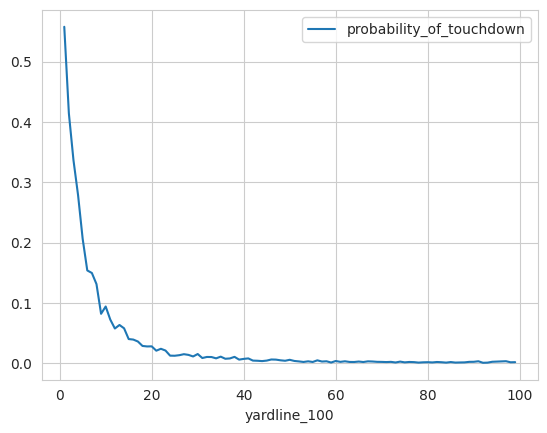

In [12]:
import seaborn as sns; sns.set_style('whitegrid');

"""
pandas.DataFrame.plot documentation

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html
"""

rushing_df_probs.plot(x='yardline_100', y='probability_of_touchdown');

In [13]:
pbp_2022 = nfl.import_pbp_data([2022])

2022 done.
Downcasting floats.


In [14]:
# Select only columns interested in
pbp_2022 = pbp_2022[['rusher_player_name', 'rusher_player_id', 'posteam', 'rush_touchdown', 'yardline_100']].dropna()

In [15]:
exp_df = pbp_2022.merge(rushing_df_probs, how='left', on='yardline_100')
exp_df.head()

,rusher_player_name,rusher_player_id,posteam,rush_touchdown,yardline_100,probability_of_touchdown
0,Mi.Carter,00-0036924,NYJ,0.0,78.0,0.001275
1,Mi.Carter,00-0036924,NYJ,0.0,59.0,0.001409
2,L.Jackson,00-0034796,BAL,0.0,64.0,0.002269
3,K.Drake,00-0033118,BAL,0.0,60.0,0.003929
4,K.Drake,00-0033118,BAL,0.0,52.0,0.003244


In [16]:
import numpy as np

"""
Now, we are grouping by Player, ID and Tm and summing up the results for probability_of_touchdown.
This is our Expected Touchdowns value, and so we rename the column on the same line.
We use agg here to only run the aggregation function on the columns we specify while also
keeping the original DataFrame intact.
More information on pandas.DataFrame.agg

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.agg.html

"""

exp_df = exp_df.groupby(['rusher_player_name', 'rusher_player_id', 'posteam'], as_index = False).agg({
    'probability_of_touchdown': np.sum,
    'rush_touchdown': np.sum
}).rename({'probability_of_touchdown': 'Expected Touchdowns'}, axis = 1)

exp_df = exp_df.sort_values(by='Expected Touchdowns', ascending = False)
exp_df.head(15)

,rusher_player_name,rusher_player_id,posteam,Expected Touchdowns,rush_touchdown
214,Ja.Williams,00-0033948,DET,17.495466,17.0
180,J.Hurts,00-0036389,PHI,15.361160,18.0
132,E.Elliott,00-0033045,DAL,11.364447,12.0
193,J.Mixon,00-0033897,CIN,11.244735,8.0
85,D.Cook,00-0033893,MIN,9.673711,8.0
182,J.Jacobs,00-0035700,LV,9.420195,12.0
346,T.Etienne,00-0036973,JAX,9.368388,6.0
270,M.Sanders,00-0035243,PHI,9.286497,13.0
95,D.Henry,00-0032764,TEN,8.947444,13.0
320,S.Barkley,00-0034844,NYG,8.941580,12.0


In [17]:
# We have still left out a lot of factors like O Line strength, athleticism, and vision.
# Rename some columns
exp_df = exp_df.rename(columns={
    "rusher_player_name": "Player",
    "posteam": "Team",
    "rusher_player_id":"ID",
    'rush_touchdown': 'Actual Touchdowns'
})

exp_df['Expected Touchdowns Rank'] = exp_df['Expected Touchdowns'].rank(ascending = False)
exp_df.head(15)

,Player,ID,Team,Expected Touchdowns,Actual Touchdowns,Expected Touchdowns Rank
214,Ja.Williams,00-0033948,DET,17.495466,17.0,1.0
180,J.Hurts,00-0036389,PHI,15.361160,18.0,2.0
132,E.Elliott,00-0033045,DAL,11.364447,12.0,3.0
193,J.Mixon,00-0033897,CIN,11.244735,8.0,4.0
85,D.Cook,00-0033893,MIN,9.673711,8.0,5.0
182,J.Jacobs,00-0035700,LV,9.420195,12.0,6.0
346,T.Etienne,00-0036973,JAX,9.368388,6.0,7.0
270,M.Sanders,00-0035243,PHI,9.286497,13.0,8.0
95,D.Henry,00-0032764,TEN,8.947444,13.0,9.0
320,S.Barkley,00-0034844,NYG,8.941580,12.0,10.0


In [22]:
exp_df['Actual Touchdowns Rank'] = exp_df['Actual Touchdowns'].rank(ascending=False)

exp_df.head()

,Player,ID,Team,Expected Touchdowns,Actual Touchdowns,Expected Touchdowns Rank,Actual Touchdowns Rank
214,Ja.Williams,00-0033948,DET,17.495466,17.0,1.0,2.0
180,J.Hurts,00-0036389,PHI,15.361160,18.0,2.0,1.0
132,E.Elliott,00-0033045,DAL,11.364447,12.0,3.0,7.5
193,J.Mixon,00-0033897,CIN,11.244735,8.0,4.0,14.5
85,D.Cook,00-0033893,MIN,9.673711,8.0,5.0,14.5


In [23]:
"""
Regression candidate is the difference between a player's Expected Touchdowns and Actual Touchdowns as
shown below. More positive numbers mean the player underperformed their season, more negative numbers
means the player overperformed their season.
"""

exp_df['Regression Candidate'] = exp_df['Expected Touchdowns'] - exp_df['Actual Touchdowns']

"""
The order of taking the difference here for the Regression Rank is reversed here as a
small actual TD rank is good, while a large actual TD rank is not.
"""

exp_df['Regression Rank Candidate'] = exp_df['Actual Touchdowns Rank'] - exp_df['Expected Touchdowns Rank']

exp_df.head()

,Player,ID,Team,Expected Touchdowns,Actual Touchdowns,Expected Touchdowns Rank,Actual Touchdowns Rank,Regression Candidate,Regression Rank Candidate
214,Ja.Williams,00-0033948,DET,17.495466,17.0,1.0,2.0,0.495466,1.0
180,J.Hurts,00-0036389,PHI,15.361160,18.0,2.0,1.0,-2.638840,-1.0
132,E.Elliott,00-0033045,DAL,11.364447,12.0,3.0,7.5,-0.635553,4.5
193,J.Mixon,00-0033897,CIN,11.244735,8.0,4.0,14.5,3.244735,10.5
85,D.Cook,00-0033893,MIN,9.673711,8.0,5.0,14.5,1.673711,9.5


In [24]:
# top negative regression candidates by looking at Expected vs. Actual
exp_df.sort_values(by='Regression Candidate').head(15)

,Player,ID,Team,Expected Touchdowns,Actual Touchdowns,Expected Touchdowns Rank,Actual Touchdowns Rank,Regression Candidate,Regression Rank Candidate
7,A.Ekeler,00-0033699,LAC,8.502165,15.0,11.0,3.0,-6.497835,-8.0
95,D.Henry,00-0032764,TEN,8.947444,13.0,9.0,4.5,-4.052556,-4.5
270,M.Sanders,00-0035243,PHI,9.286497,13.0,8.0,4.5,-3.713503,-3.5
349,T.Hill,00-0033357,NO,3.290649,7.0,51.0,20.5,-3.709351,-30.5
362,T.Pollard,00-0035261,DAL,5.319830,9.0,32.0,11.0,-3.680170,-21.0
281,N.Chubb,00-0034791,CLE,8.322065,12.0,13.0,7.5,-3.677935,-5.5
69,C.Patterson,00-0030578,ATL,4.781485,8.0,33.0,14.5,-3.218515,-18.5
320,S.Barkley,00-0034844,NYG,8.941580,12.0,10.0,7.5,-3.058420,-2.5
180,J.Hurts,00-0036389,PHI,15.361160,18.0,2.0,1.0,-2.638840,-1.0
182,J.Jacobs,00-0035700,LV,9.420195,12.0,6.0,7.5,-2.579805,1.5


In [25]:
# top positive regression candidates by looking at Expected vs. Actual
exp_df.sort_values(by='Regression Candidate', ascending=False).head(15)

,Player,ID,Team,Expected Touchdowns,Actual Touchdowns,Expected Touchdowns Rank,Actual Touchdowns Rank,Regression Candidate,Regression Rank Candidate
334,T.Allgeier,00-0037263,ATL,6.659283,3.0,19.0,54.5,3.659283,35.5
242,L.Fournette,00-0033856,TB,6.463384,3.0,21.0,54.5,3.463384,33.5
36,B.Robinson,00-0037746,WAS,5.415726,2.0,31.0,78.0,3.415726,47.0
346,T.Etienne,00-0036973,JAX,9.368388,6.0,7.0,24.5,3.368388,17.5
193,J.Mixon,00-0033897,CIN,11.244735,8.0,4.0,14.5,3.244735,10.5
8,A.Gibson,00-0036328,WAS,6.185598,3.0,23.0,54.5,3.185598,31.5
190,J.McKinnon,00-0031376,KC,3.805824,1.0,43.0,126.0,2.805824,83.0
261,M.Gordon,00-0032144,DEN,4.095265,2.0,38.0,78.0,2.095265,40.0
113,D.Pierce,00-0037258,HOU,5.994860,4.0,24.0,40.5,1.994860,16.5
317,R.White,00-0037256,TB,2.865525,1.0,61.0,126.0,1.865525,65.0


In [26]:
exp_df.loc[exp_df['Expected Touchdowns'] > 2].sort_values(by = 'Regression Rank Candidate', ascending = True).head(15)

,Player,ID,Team,Expected Touchdowns,Actual Touchdowns,Expected Touchdowns Rank,Actual Touchdowns Rank,Regression Candidate,Regression Rank Candidate
349,T.Hill,00-0033357,NO,3.290649,7.0,51.0,20.5,-3.709351,-30.5
14,A.Mattison,00-0034972,MIN,3.189504,5.0,54.0,31.0,-1.810496,-23.0
219,K.Drake,00-0033118,BAL,2.746762,4.0,63.0,40.5,-1.253238,-22.5
362,T.Pollard,00-0035261,DAL,5.319830,9.0,32.0,11.0,-3.680170,-21.0
267,M.Mariota,00-0032268,ATL,2.921246,4.0,60.0,40.5,-1.078754,-19.5
69,C.Patterson,00-0030578,ATL,4.781485,8.0,33.0,14.5,-3.218515,-18.5
210,J.Wilson,00-0034115,MIA,3.063972,4.0,58.0,40.5,-0.936028,-17.5
93,D.Harris,00-0035657,NE,2.294788,3.0,72.0,54.5,-0.705212,-17.5
218,K.Cousins,00-0029604,MIN,2.338966,3.0,71.0,54.5,-0.661034,-16.5
51,C.Edwards-Helaire,00-0036360,KC,2.378933,3.0,70.0,54.5,-0.621067,-15.5


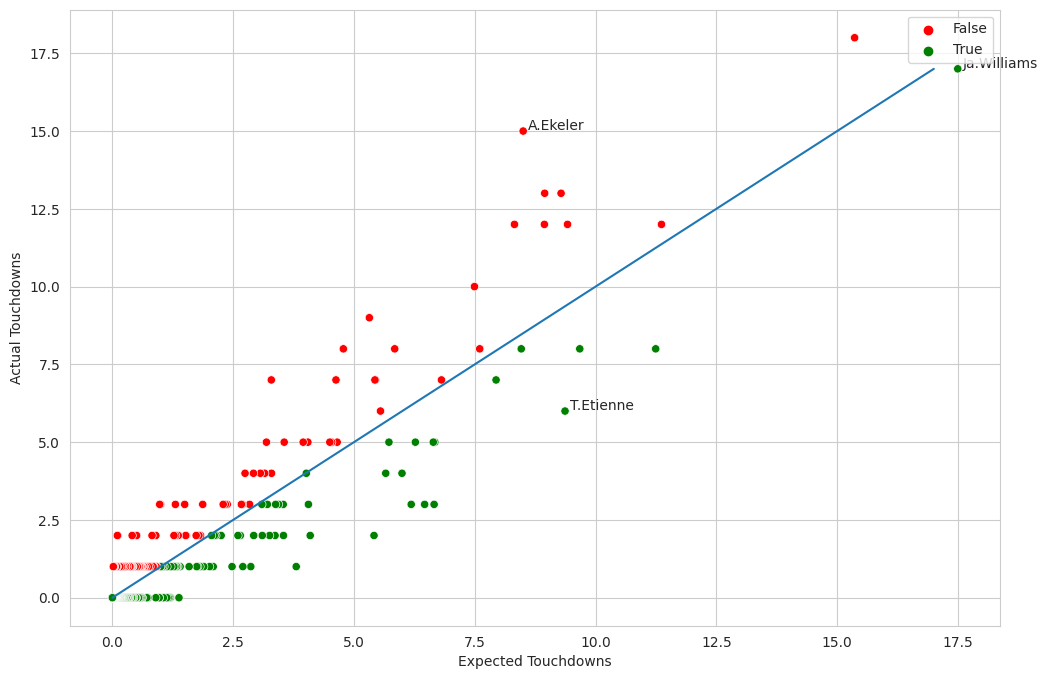

In [27]:
from matplotlib import pyplot as plt;

# using the object-oriented API for greater control over our plots. Setting figsize on the same line.
fig, ax = plt.subplots(figsize=(12, 8))

# creating a new column with either True/False based on if Regression Candidate is a positive number
exp_df['Positive Regression Candidate'] = exp_df['Regression Candidate'] > 0

# simple scatter plot
sns.scatterplot(
    x = 'Expected Touchdowns',
    y = 'Actual Touchdowns',
    hue = 'Positive Regression Candidate',
    data = exp_df,
    palette = ['r', 'g'] # red and green
);

max_act_touchdowns = int(exp_df['Actual Touchdowns'].max()) # max touchdowns
max_exp_touchdowns = int(exp_df['Expected Touchdowns'].max()) # max expected touchdowns

max_tds = max(max_act_touchdowns, max_exp_touchdowns) # max of actual and expected tds

sns.lineplot(x=range(max_tds), y=range(max_tds)) # plotting a line with slope of 1 up to max_tds number. This is the blue line on our viz

# initialize a list of notable players we'd like to annotate the visualization with.
notable_players = ['T.Etienne', 'Ja.Williams', 'A.Ekeler']

for _, row in exp_df.iterrows():
    if row['Player'] in notable_players:
        """
        Check our the docs on Axes.text

        https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.text.html

        Notice we are using the ax object we instantiated above.
        """
        ax.text(
            x = row['Expected Touchdowns']+.1, # add a bit of spacing from the point in the x-direction
            y = row['Actual Touchdowns'] + 0.05, # same but in the y-direction
            s = row['Player'] # annotate with the player's name
        )